In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
# PREPROCESSING MODULE
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# DIMENSION REDUCTION MODULE
from sklearn.decomposition import FastICA, PCA
from sklearn import random_projection
from sklearn.decomposition import TruncatedSVD

# CLUSTERING MODULE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score

# MODEL SELECTION MODULE
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

#from sklearn.neural_network import MLPClassifier

import time

In [2]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]
    
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

def generate_kmeans_SV_ICD_plots(X, k):
    plot_nums = len(k)
    fig, axes = plt.subplots(plot_nums, 2, figsize=[25, 40])
    col_ = 0
    for i in k:
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[col_][0])
        visualizer.fit(X)
        visualizer.finalize()
        
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = InterclusterDistance(kmeans, ax=axes[col_][1])
        visualizer.fit(X)
        visualizer.finalize()
        
        col_+=1
    plt.show()
    
def generate_silhoutte_score_plot(X, k, model):
    n_clusters=np.arange(2, k)
    sils=[]
    sils_err=[]
    iterations=k
    for n in n_clusters:
        tmp_sil=[]
        for _ in range(iterations):
            clf=model(n).fit(X) 
            labels=clf.predict(X)
            sil=metrics.silhouette_score(X, labels, metric='euclidean')
            tmp_sil.append(sil)
        val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
        err=np.std(tmp_sil)
        sils.append(val)
        sils_err.append(err)
    plt.errorbar(n_clusters, sils, yerr=sils_err)
    plt.title("Silhouette Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of clusters ({})".format("Test"))
    plt.ylabel("Score")



## Data loading and preprocessing

In [3]:
full_data = pd.read_csv('glass.data')

In [4]:
full_data.isnull().values.any()
full_data2=full_data.dropna(axis=0)

In [5]:
X = full_data2.iloc[:, 0:9]
Y = full_data2.iloc[:, -1]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, 
                                                    random_state = 3)

In [7]:
scaler = StandardScaler()

In [8]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### PCA

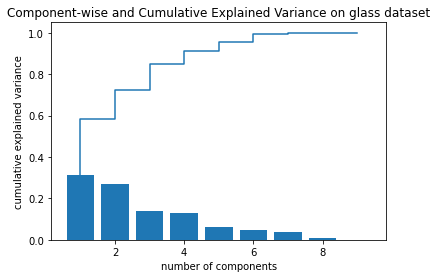

In [9]:
pca = PCA().fit(X_train_scaled)

# https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_,label = 'Individual explained variance')
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_),label = 'Cumulative explained variance')
plt.title("Component-wise and Cumulative Explained Variance on glass dataset")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Calculating Reconstruction Error


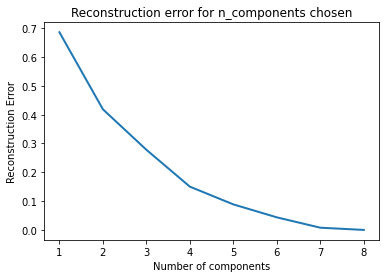

In [10]:
#Reconstruction Error
from sklearn.model_selection import GridSearchCV
print("Calculating Reconstruction Error")
n_components =[1,2,3,4,5,6,7,8]
reconstruction_error = []
for comp in n_components:

 pca = PCA(n_components = comp)
 X_transformed = pca.fit_transform(X_train_scaled)
 X_projected = pca.inverse_transform(X_transformed)
 reconstruction_error.append(((X_train_scaled - X_projected) ** 2).mean())

 #if(comp == gridSearch.best_estimator_.named_steps['pca'].n_components):
  #chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
#ax2.axvline(gridSearch.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen')
plt.show()

In [11]:
# # Choose the number of components that capture 85% of the variance
# num_components = 10

# # Transform the data
# pca = PCA(n_components=num_components)
# pca.fit(X_train_scaled)
# X_train_pca = pca.transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)
n=5
start = time.time()
pca = PCA(n_components= n).fit(X_train_scaled)
print("Time(s) " + str(time.time() - start))
print("original shape:", X_train_scaled.shape)
X_pca = pca.transform(X_train_scaled)
print("transformed shape:", X_pca.shape)
print()

Time(s) 0.0
original shape: (170, 9)
transformed shape: (170, 5)



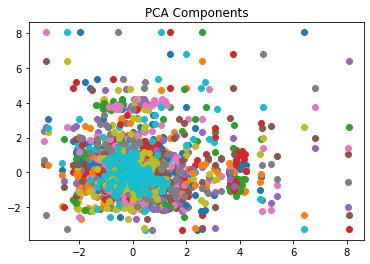

In [12]:
plt.figure(figsize=(6,4))
plt.title('PCA Components')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(X_pca[:,i], X_pca[:,j])

In [13]:
 #RECONSTRUCTION ERROR
pca = PCA(n_components = 5)
X_test_transformed = pca.fit_transform(X_test_scaled)
X_test_projected = pca.inverse_transform(X_test_transformed)
test_reconstruction_error=((X_test_scaled - X_test_projected) ** 2).mean()
print(test_reconstruction_error)

0.058596313778559735


### ICA

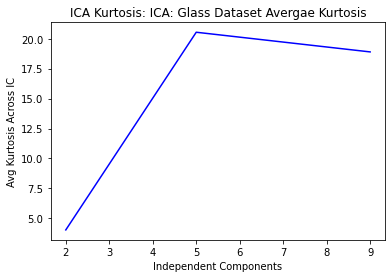

In [14]:
def run_ICA(X,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    ica = FastICA(random_state=4)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

run_ICA(X_train_scaled,"ICA: Glass Dataset Avergae Kurtosis")

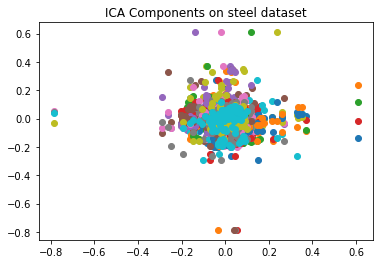

In [15]:
n = 5
ica = FastICA(n_components=n, max_iter=10000, tol=0.1) 
X_ica=ica.fit_transform(X_train_scaled)

plt.figure(figsize=(6,4))
plt.title('ICA Components on steel dataset')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(X_ica[:,i], X_ica[:,j])

In [16]:
n=5
start = time.time()
ica = FastICA(n_components=n, max_iter=10000, tol=0.1) 

print("Time(s) " + str(time.time() - start))
print("original shape:", X_train_scaled.shape)
X_ica=ica.fit_transform(X_train_scaled)
print("transformed shape:", X_ica.shape)
print()

Time(s) 0.0
original shape: (170, 9)
transformed shape: (170, 5)



In [17]:
#RECONSTRUCTION ERROR
ica = FastICA(n_components = 5)
X_test_transformed = ica.fit_transform(X_test_scaled)
X_test_projected = ica.inverse_transform(X_test_transformed)
test_reconstruction_error=((X_test_scaled - X_test_projected) ** 2).mean()
print(test_reconstruction_error)

0.05859631377855974


### RP

Calculating Reconstruction Error


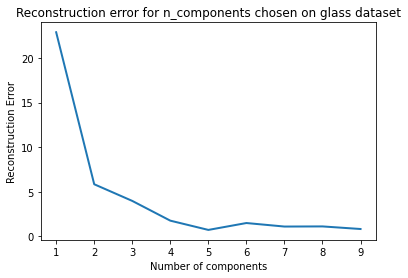

In [18]:
#Reconstruction Error

print("Calculating Reconstruction Error")

n_components =[1,2,3,4,5,6,7,8, 9]

def inverse_transform_rp(rp, X_transformed, X_train):

    return X_transformed.dot(rp.components_) + np.mean(X_train, axis = 0)


reconstruction_error = []
for comp in n_components:

    rp = random_projection.GaussianRandomProjection(n_components = comp)
    X_transformed = rp.fit_transform(X_train_scaled)
    X_projected = inverse_transform_rp(rp, X_transformed, X_train_scaled)
    reconstruction_error.append(((X_train_scaled - X_projected) ** 2).mean())

 #if(comp == gridSearch.best_estimator_.named_steps['rp'].n_components):
  #chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
#ax2.axvline(gridSearch.best_estimator_.named_steps['rp'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen on glass dataset')
plt.show()

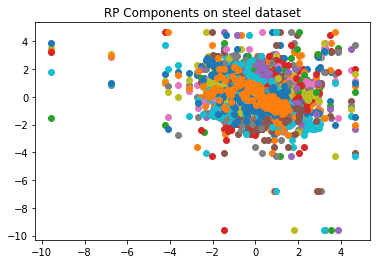

In [19]:
n = 7
rp = random_projection.GaussianRandomProjection(n_components = n)
X_rp=rp.fit_transform(X_train_scaled)

plt.figure(figsize=(6,4))
plt.title('RP Components on steel dataset')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(X_rp[:,i], X_rp[:,j])

In [20]:
n=7
start = time.time()
rp = random_projection.GaussianRandomProjection(n_components = n) 

print("Time(s) " + str(time.time() - start))
print("original shape:", X_train_scaled.shape)
X_rp=rp.fit_transform(X_train_scaled)
print("transformed shape:", X_ica.shape)
print()

Time(s) 0.0
original shape: (170, 9)
transformed shape: (170, 5)



In [21]:
#RECONSTRUCTION ERROR
rp = random_projection.GaussianRandomProjection(n_components = 7)
X_test_transformed = rp.fit_transform(X_test_scaled)
X_test_projected = inverse_transform_rp(rp, X_test_transformed, X_test_scaled)
test_reconstruction_error=((X_test_scaled - X_test_projected) ** 2).mean()
print(test_reconstruction_error)

2.1137440901561506


### SVD

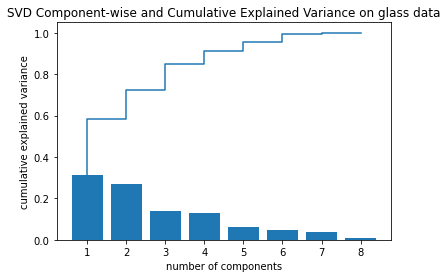

In [22]:
tsvd = TruncatedSVD(n_components=X.shape[1]-1)
X_tsvd = tsvd.fit(X_train_scaled)
# https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/
plt.bar(range(1, len(X_tsvd.explained_variance_ratio_) + 1), X_tsvd.explained_variance_ratio_,label = 'Individual explained variance')
plt.step(range(1, len(X_tsvd.explained_variance_ratio_) + 1), np.cumsum(X_tsvd.explained_variance_ratio_),label = 'Cumulative explained variance')
plt.title("SVD Component-wise and Cumulative Explained Variance on glass data")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Calculating Reconstruction Error


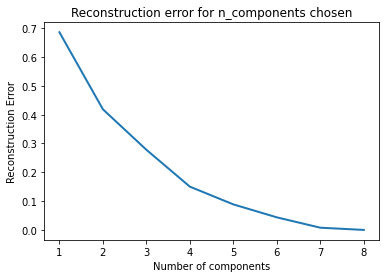

In [23]:
#Reconstruction Error
from sklearn.model_selection import GridSearchCV
print("Calculating Reconstruction Error")
n_components =[1,2,3,4,5,6,7,8]
reconstruction_error = []

for comp in n_components:
    tsvd = TruncatedSVD(n_components = comp)
    X_transformed = tsvd.fit_transform(X_train_scaled)
    X_projected = tsvd.inverse_transform(X_transformed)
    reconstruction_error.append(((X_train_scaled - X_projected) ** 2).mean())

#if(comp == gridSearch.best_estimator_.named_steps['pca'].n_components):
#chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
#ax2.axvline(gridSearch.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen')
plt.show()

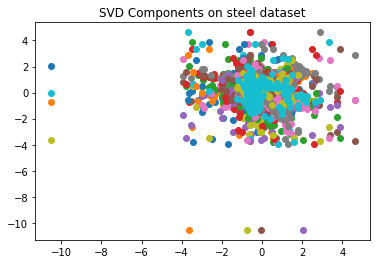

In [24]:
n = 5
tsvd = TruncatedSVD(n_components = n)
X_tsvd=tsvd.fit_transform(X_train_scaled)

plt.figure(figsize=(6,4))
plt.title('SVD Components on steel dataset')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(X_rp[:,i], X_rp[:,j])

In [25]:
n=5
start = time.time()
tsvd = TruncatedSVD(n_components = n)

print("Time(s) " + str(time.time() - start))
print("original shape:", X_train_scaled.shape)
X_tsvd=tsvd.fit_transform(X_train_scaled)
print("transformed shape:", X_tsvd.shape)
print()

Time(s) 0.0
original shape: (170, 9)
transformed shape: (170, 5)



In [26]:
 #RECONSTRUCTION ERROR
tsvd = TruncatedSVD(n_components = 5)
X_test_transformed = tsvd.fit_transform(X_test_scaled)
X_test_projected = tsvd.inverse_transform(X_test_transformed)
test_reconstruction_error=((X_test_scaled - X_test_projected) ** 2).mean()
print(test_reconstruction_error)

0.062475839034255326


## DR+Clustering

### PCA + KMeans

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


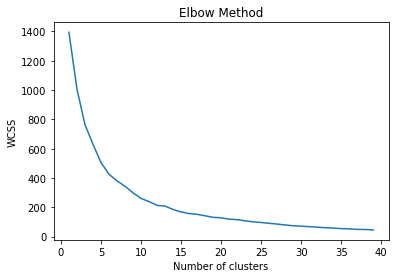

In [27]:
wcss = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 40), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

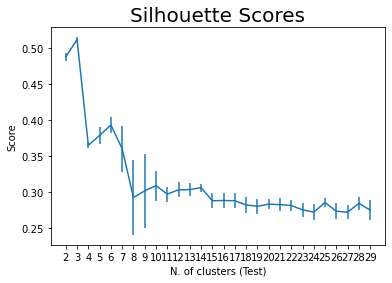

In [28]:
generate_silhoutte_score_plot(X_pca, 30, KMeans)

For n_clusters = 2 The average silhouette_score is : 0.6212548554123781
For n_clusters = 3 The average silhouette_score is : 0.5796250550647278
For n_clusters = 4 The average silhouette_score is : 0.5578696374348995
For n_clusters = 5 The average silhouette_score is : 0.5412845867180843
For n_clusters = 6 The average silhouette_score is : 0.5296747370528888
For n_clusters = 7 The average silhouette_score is : 0.5172872247232703
For n_clusters = 8 The average silhouette_score is : 0.5110680859603707


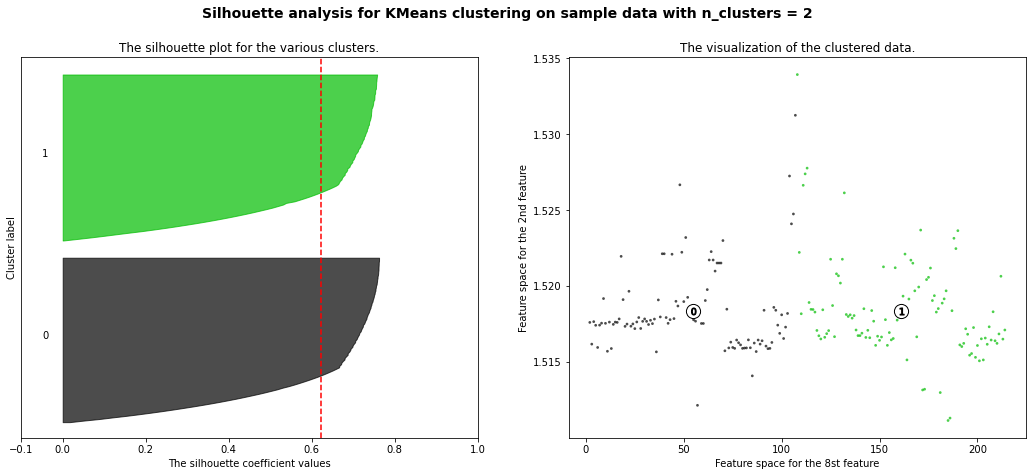

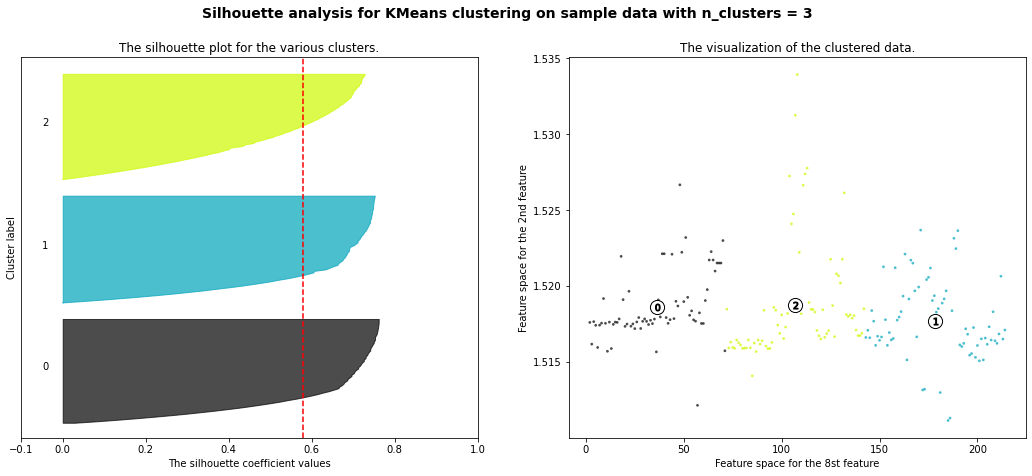

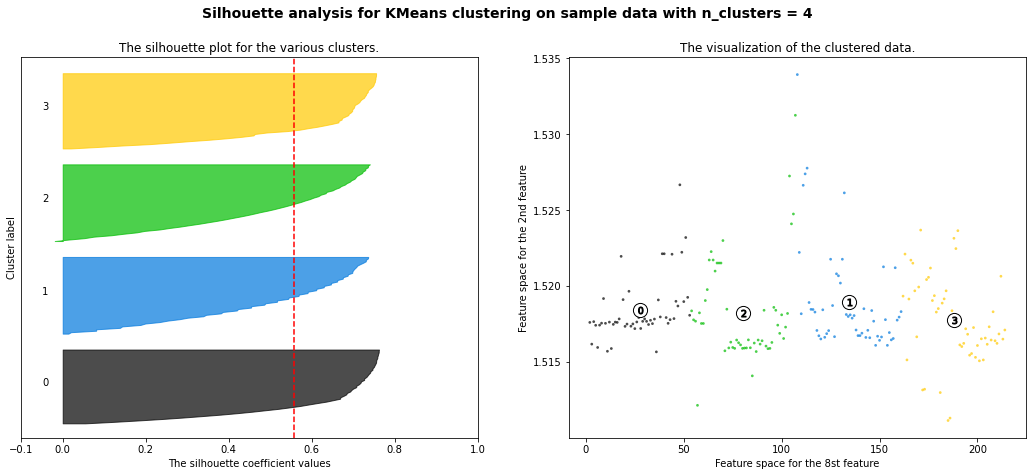

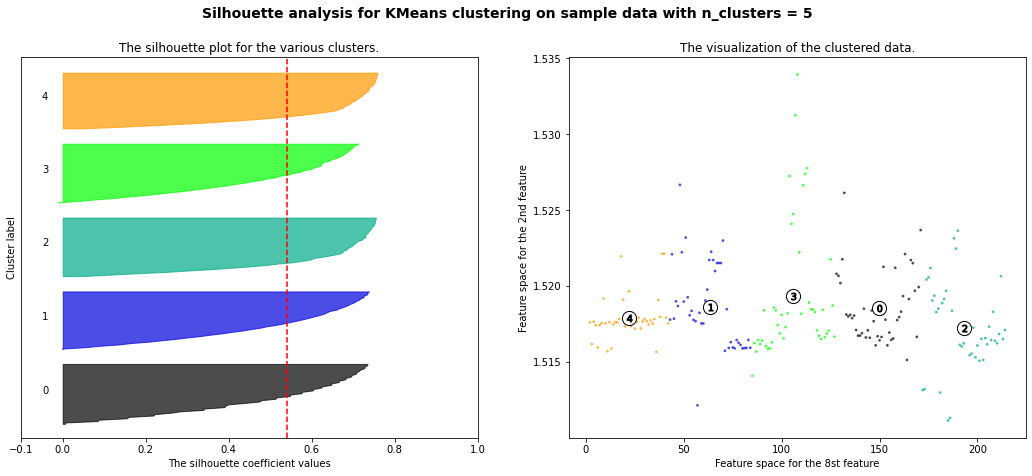

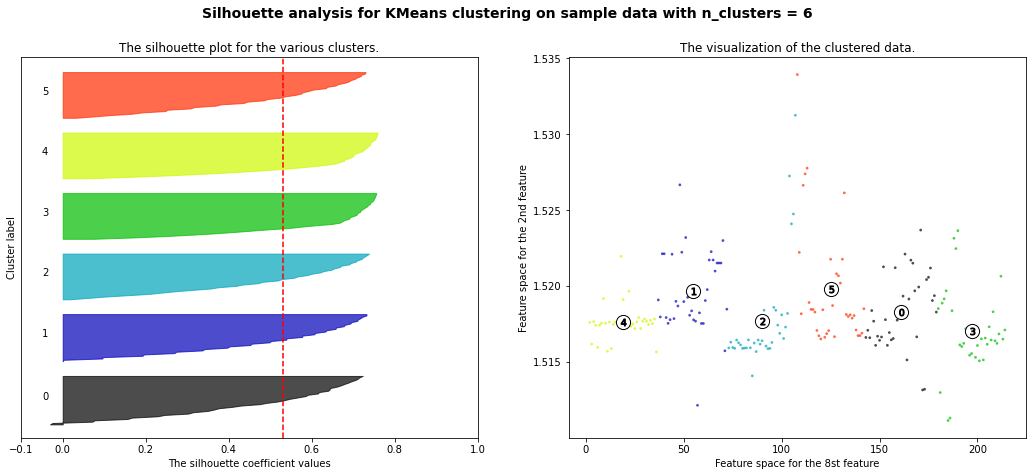

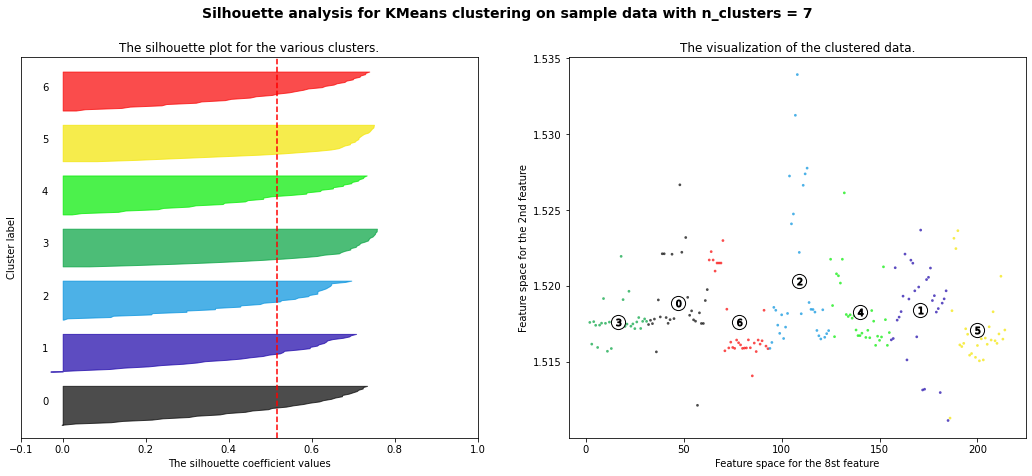

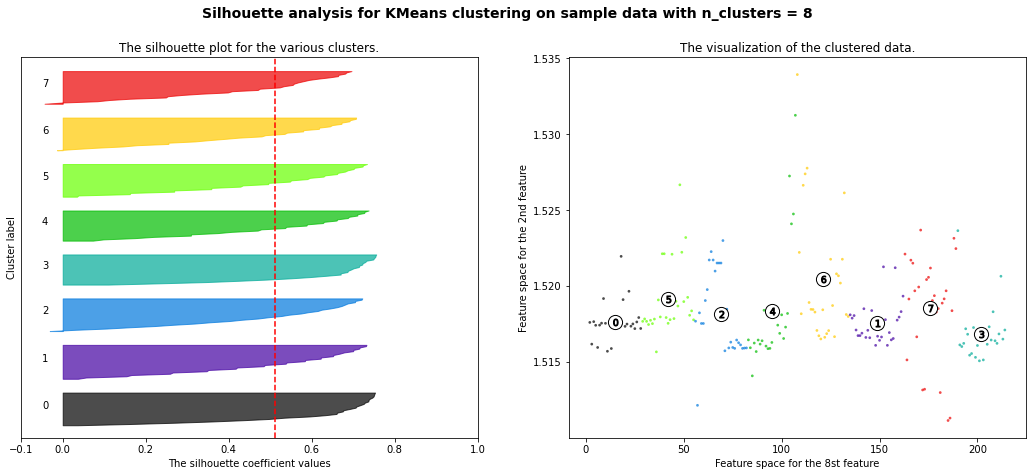

In [30]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2,3,4,5,6,7,8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 8st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [29]:
kmeans = KMeans(n_clusters=6, max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_pca)
from sklearn.metrics.cluster import rand_score
rand_score(y_train, kmeans.predict(X_pca))

0.6847198050817961

### ICA + KMeans

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


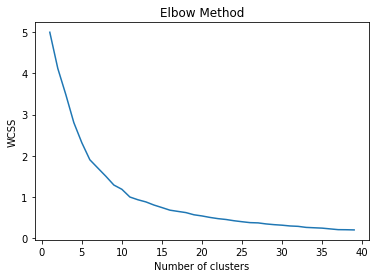

In [32]:
wcss = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_ica)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 40), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

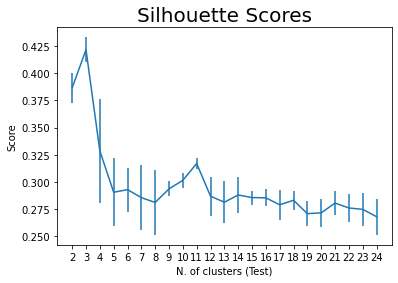

In [33]:
generate_silhoutte_score_plot(X_ica, 25, KMeans)

In [34]:
kmeans = KMeans(n_clusters=6, max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_ica)
from sklearn.metrics.cluster import rand_score
rand_score(y_train, kmeans.predict(X_ica))

0.6788026453184824

### RP + KMeans

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


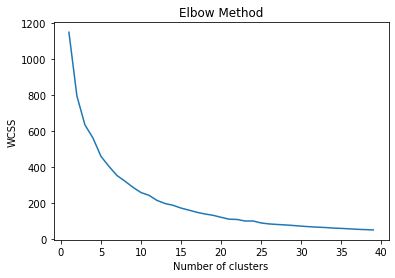

In [35]:
wcss = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_rp)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 40), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

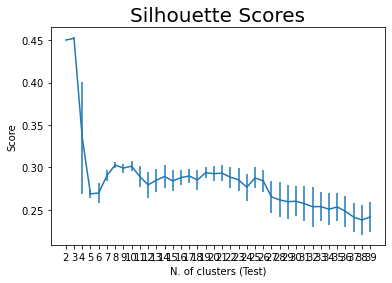

In [36]:
generate_silhoutte_score_plot(X_rp, 40, KMeans)

In [37]:
kmeans = KMeans(n_clusters=7, max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_rp)
from sklearn.metrics.cluster import rand_score
rand_score(y_train, kmeans.predict(X_rp))

0.7346327880264532

### SVD + KMeans

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


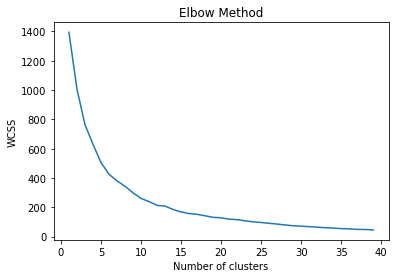

In [38]:
wcss = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_tsvd)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 40), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

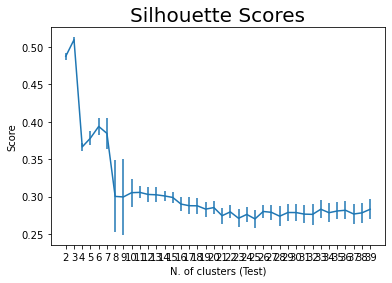

In [39]:
generate_silhoutte_score_plot(X_tsvd, 40, KMeans)

In [40]:
kmeans = KMeans(n_clusters=7, max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_tsvd)
from sklearn.metrics.cluster import rand_score
rand_score(y_train, kmeans.predict(X_tsvd))

0.6881308736512356

### PCA + GMM

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

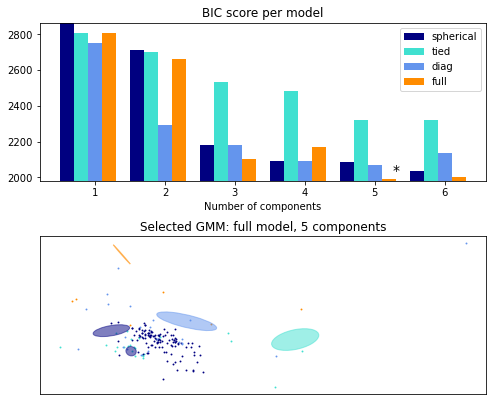

In [41]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_pca)
        bic.append(gmm.bic(X_pca))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_pca)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_pca[Y_ == i, 3], X_pca[Y_ == i, 2], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [ ]:
from sklearn.metrics.cluster import rand_score
rand_score(y_train, best_gmm.predict(X_pca))

### ICA + GMM

In [ ]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_ica)
        bic.append(gmm.bic(X_ica))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_ica)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_ica[Y_ == i, 2], X_ica[Y_ == i, 0], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [ ]:
from sklearn.metrics.cluster import rand_score
rand_score(y_train, best_gmm.predict(X_ica))

### RP + GMM

In [ ]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_rp)
        bic.append(gmm.bic(X_rp))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_rp)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_rp[Y_ == i, 0], X_rp[Y_ == i, 1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [ ]:
from sklearn.metrics.cluster import rand_score
rand_score(y_train, best_gmm.predict(X_rp))

### SVD + GMM

In [ ]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_tsvd)
        bic.append(gmm.bic(X_tsvd))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_tsvd)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_tsvd[Y_ == i, 0], X_tsvd[Y_ == i, 1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()